# Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [195]:
## Importing Important Libraries
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from collections import Counter

pd.set_option('max_columns',None)

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from IPython.display import Image
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')


In [196]:
df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [197]:
# Shape of the dataset
df.shape

(32560, 15)

The dataset has 32560 rows and 15 columns

In [198]:
# See the datatypes of the dataset
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

The dataset has categorical and numerical columns.


Categorical columns are : Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country and Income 

Rest of the columns are in numerical format

In [199]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

<AxesSubplot:>

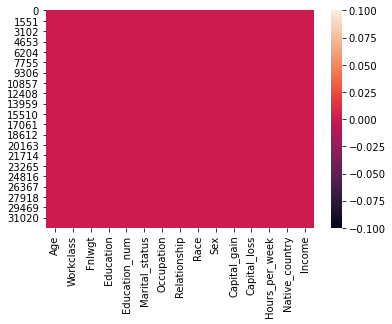

In [200]:
sns.heatmap(df.isnull())

There are no null values in the dataset but observed that dataset have ? in some columns , so  have to deal with it.

In [201]:
# It gives the unique values of all the columns
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

Our target variable has 2 unique values i.e. >50k and <50k

# Value Count function

In [202]:
#all the data types and their unique values
for column in df.columns:
    if df[column].dtype == object:
        print(str(column) + ': ' +str(df[column].unique()))
        print(df[column].value_counts())
        print('\n')

Workclass: [' Self-emp-not-inc' ' Private' ' State-gov' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64


Education: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtyp

Workclass ,Occupation, Native_country having unknown '?' value

In [203]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


==> Mean is greather than median in Age, Capital_gain and Capital_loss columns

==>Std is also high in Capital_gain,Capital_loss columns, so skewness is present

==>There is huge difference 75 % and max values in all columns axcept Fnlgwgt,so outliers must be present

==>The minm value for Education_num and Hours_per_week is 1 whereas the max value is 16 and 99 respectively

In [204]:
df['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

Private has highest no of rows i.e. 22696 

? has also large no of rows i.e. 1836 , so we can't drop these rows

In [205]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [206]:
df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

Prof-specialty  has highest no of rows i.e. 4140

? has also 1843 rows

In [207]:
df['Native_country'].value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

United-States has highest no of rows 29169 rows

? has 583 values

In [208]:
df['Race'].value_counts()

 White                 27815
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: Race, dtype: int64

white people are more in numbers compared to others 

In [209]:
df['Sex'].value_counts()

 Male      21789
 Female    10771
Name: Sex, dtype: int64

Male are greater in numbers than female

In [210]:
df['Income'].value_counts()

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64

Our target variable Income has imbalance data , so we have to balance using over sampling or under sampling

<AxesSubplot:xlabel='Income', ylabel='count'>

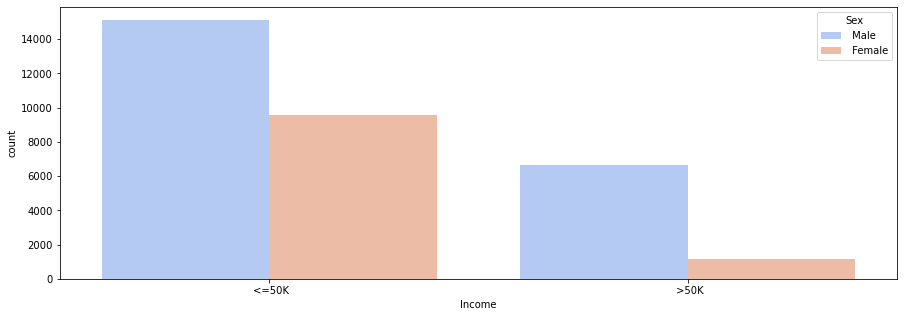

In [211]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Sex', data=df)

Around 14k male and 9k females have income <=50k whereas 6k males and 1k females have income >50k

<AxesSubplot:xlabel='Income', ylabel='count'>

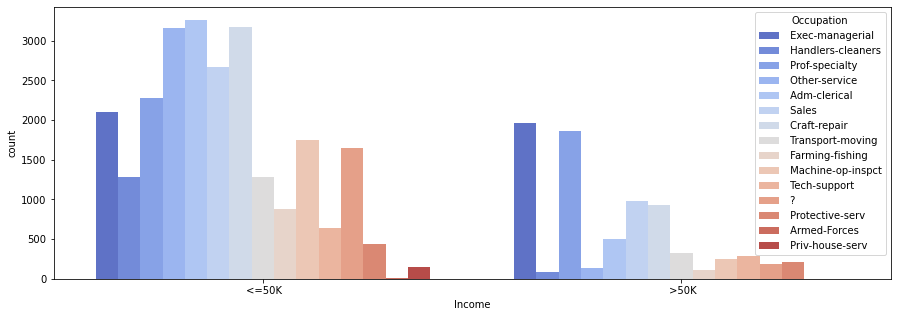

In [212]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Occupation', data=df)

Adm-clerical people are highest in numbers whose salary <=50k and Exec-managerial are more whose salary >=50k

<AxesSubplot:xlabel='Income', ylabel='count'>

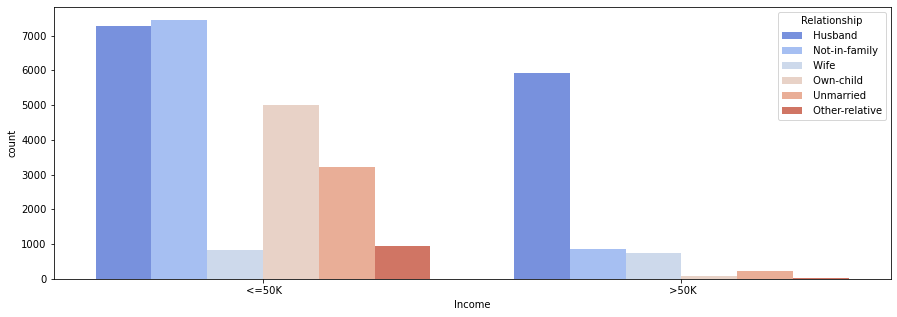

In [213]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Relationship', data=df)

Husband have income >50k and the persons who are not in family have income <50k

<AxesSubplot:xlabel='Income', ylabel='count'>

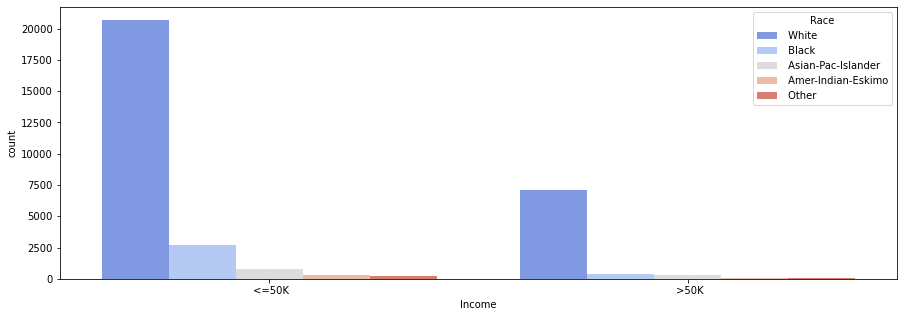

In [214]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Race', data=df)

White peoples are more compared to others whose salary >50k and <50k

<AxesSubplot:xlabel='Income', ylabel='count'>

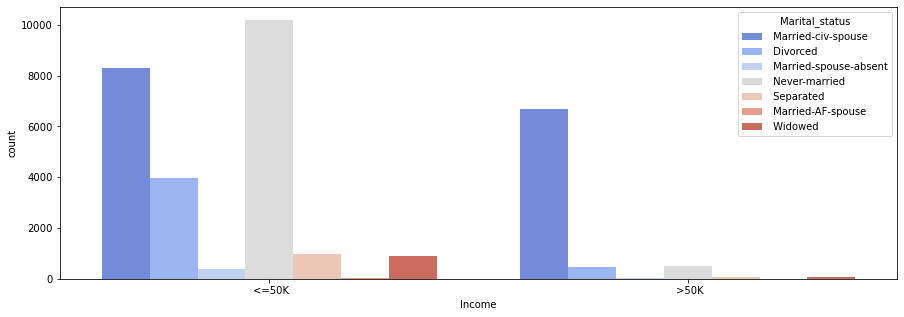

In [215]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Marital_status', data=df)

The people who never married have salary <50k 

<AxesSubplot:xlabel='Income', ylabel='count'>

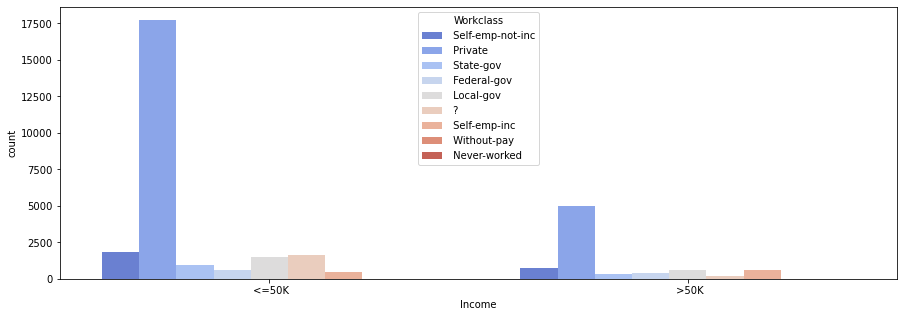

In [216]:
plt.figure(figsize= (15,5))
sns.countplot(df['Income'], palette='coolwarm', hue='Workclass', data=df)

Private people are more in number who earns more than >50k while others are less

# Filling missing values

In [217]:
# Replace the values with mode

In [218]:
df['Workclass'] = df['Workclass'].str.replace('?','Private',regex=True)
df['Occupation'] = df['Occupation'].str.replace('?' , 'Prof-specialty',regex=True)
df['Native_country'] = df['Native_country'].str.replace('?' , 'United-States',regex=True)

In [219]:
df['Workclass'].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [220]:
df['Occupation'].value_counts()

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [221]:
df.head(10)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K


# Feature Engineering

In [222]:
df['Marital_status'] = df['Marital_status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
df.Marital_status = df.Marital_status.replace(['Never-married'], 'Not-Married')
df.Marital_status = df.Marital_status.replace(['Married-spouse-absent', 'Divorced','Separated','Widowed'], 'Others')

In [223]:
df['Education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64

In [224]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [225]:
dfcor=df.corr()
dfcor

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
Fnlwgt,-0.076646,1.000000,-0.043159,0.000437,-0.010259,-0.018770
Education_num,0.036527,-0.043159,1.000000,0.122627,0.079932,0.148127
Capital_gain,0.077674,0.000437,0.122627,1.000000,-0.031614,0.078409
Capital_loss,0.057775,-0.010259,0.079932,-0.031614,1.000000,0.054256
Hours_per_week,0.068756,-0.018770,0.148127,0.078409,0.054256,1.000000


<AxesSubplot:>

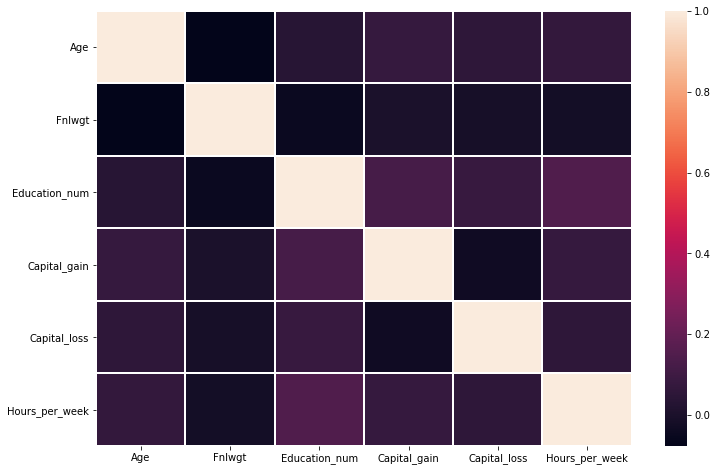

In [226]:
plt.figure(figsize=(12,8))
sns.heatmap(dfcor,linewidths=1)

<AxesSubplot:>

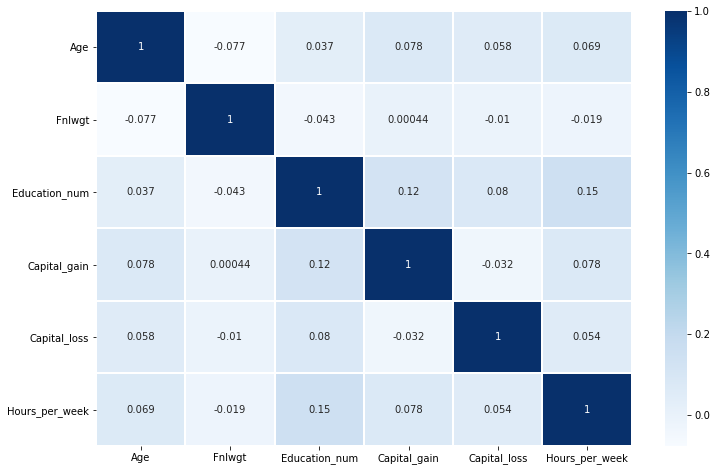

In [227]:
plt.figure(figsize=(12,8))
sns.heatmap(dfcor,cmap='Blues',annot=True,linewidths=1)

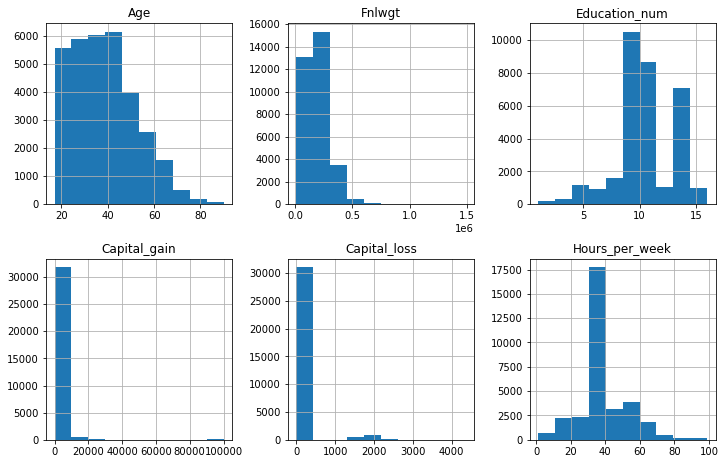

In [228]:
df.hist(figsize=(12,12), layout=(3,3), sharex=False);

# Boxplot (To find Outliers)

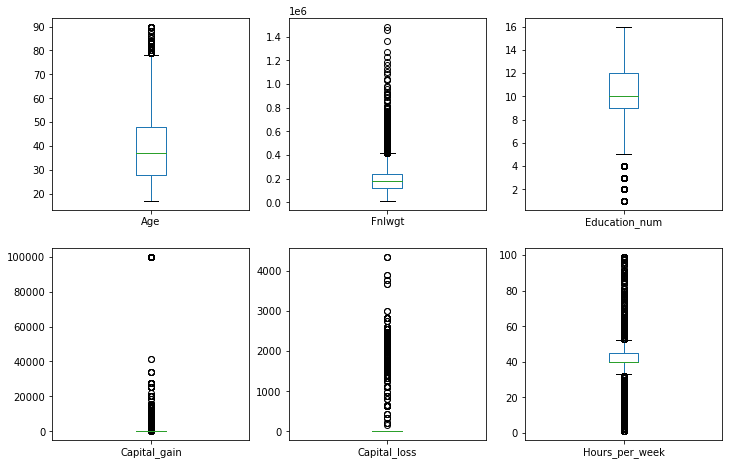

In [229]:
df.plot(kind='box', figsize=(12,12), layout=(3,3), sharex=False, subplots=True);

<AxesSubplot:xlabel='Race', ylabel='count'>

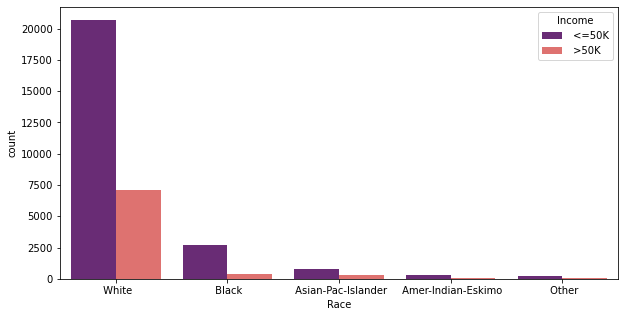

In [230]:
plt.figure(figsize=[10,5])
sns.countplot(df['Race'], hue ='Income', data=df,palette='magma')

<AxesSubplot:xlabel='Education', ylabel='count'>

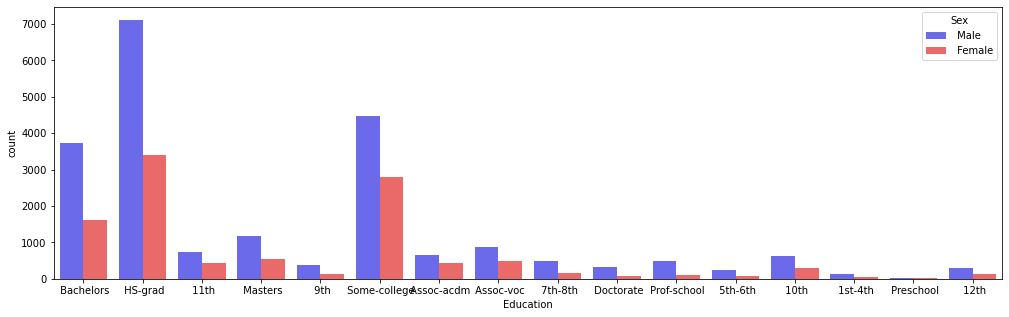

In [231]:
plt.figure(figsize=[17,5])
sns.countplot(df['Education'], hue ='Sex', data=df,palette='seismic')

<AxesSubplot:xlabel='Occupation', ylabel='count'>

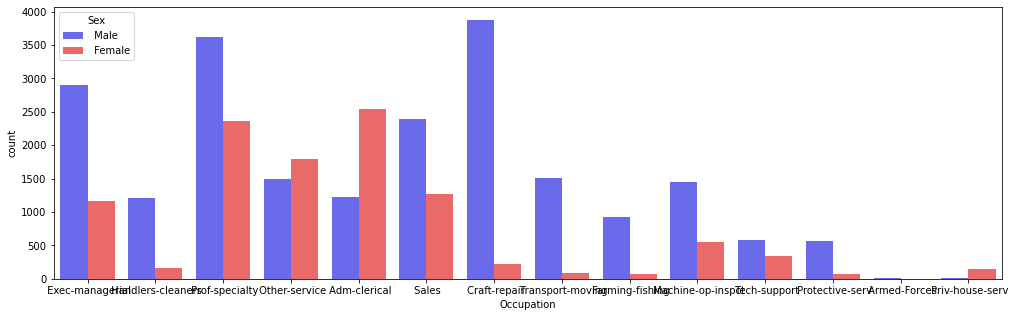

In [232]:
plt.figure(figsize=[17,5])
sns.countplot(df['Occupation'], hue ='Sex', data=df,palette='seismic')

<AxesSubplot:xlabel='Marital_status', ylabel='count'>

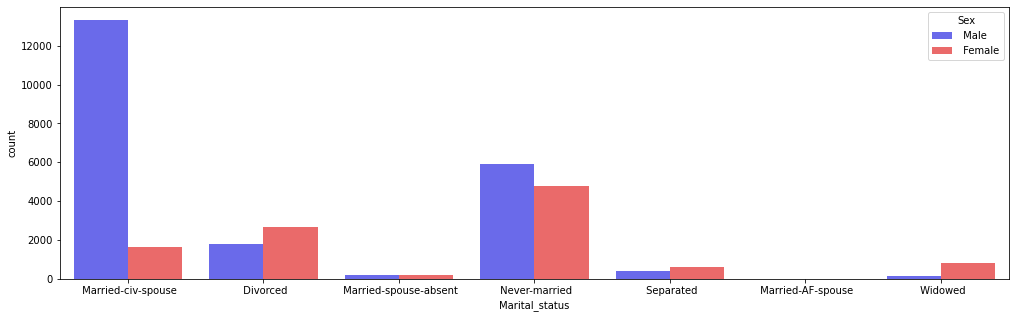

In [233]:
plt.figure(figsize=[17,5])
sns.countplot(df['Marital_status'], hue ='Sex', data=df,palette='seismic')

<AxesSubplot:xlabel='Native_country', ylabel='count'>

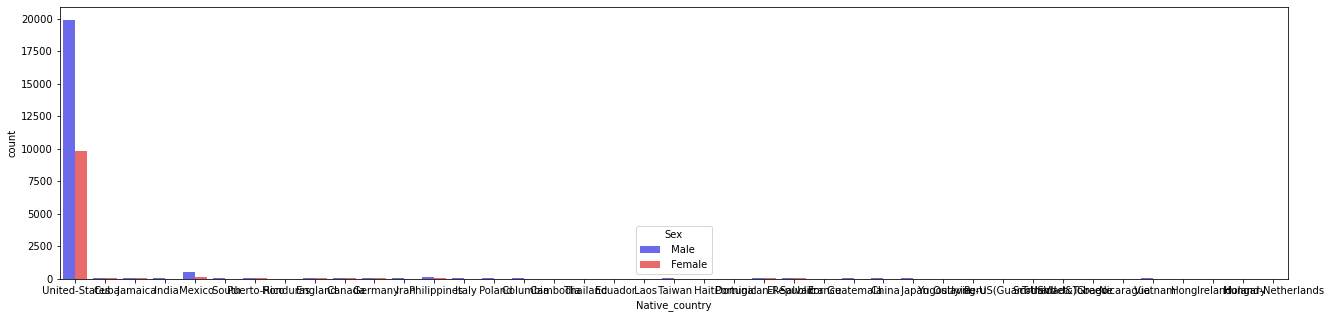

In [234]:
plt.figure(figsize=[22,5])
sns.countplot(df['Native_country'], hue ='Sex', data=df,palette='seismic')

<AxesSubplot:xlabel='Workclass', ylabel='count'>

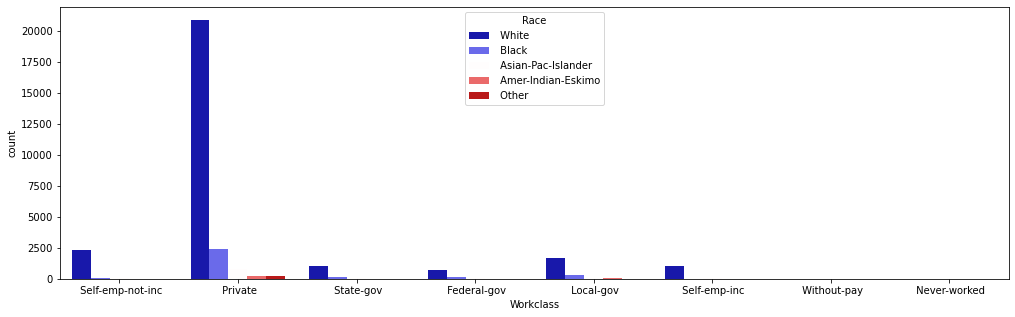

In [235]:
plt.figure(figsize=[17,5])
sns.countplot(df['Workclass'], hue ='Race', data=df,palette='seismic')

<AxesSubplot:xlabel='Workclass', ylabel='count'>

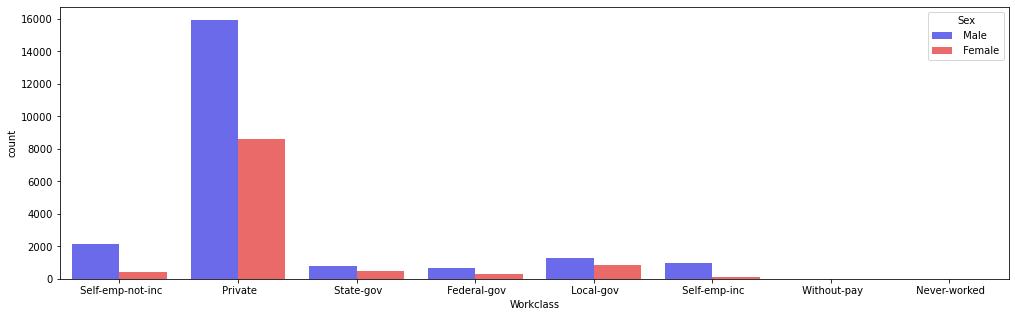

In [236]:
plt.figure(figsize=[17,5])
sns.countplot(df['Workclass'], hue ='Sex', data=df,palette='seismic')

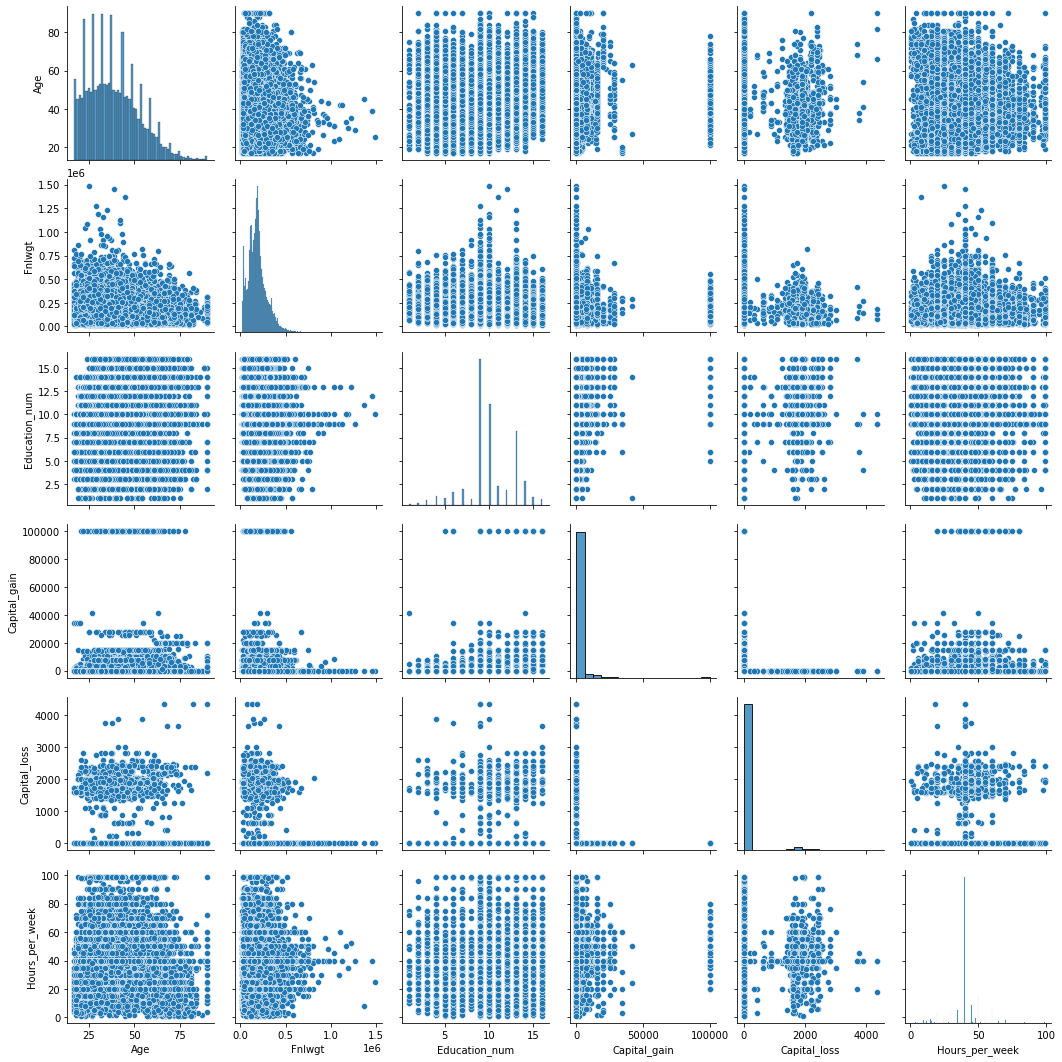

In [238]:
sns.pairplot(df)

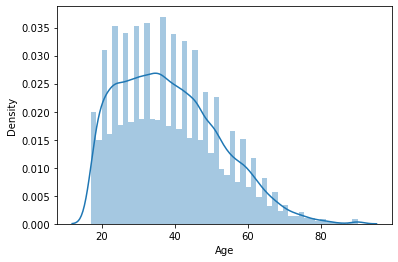

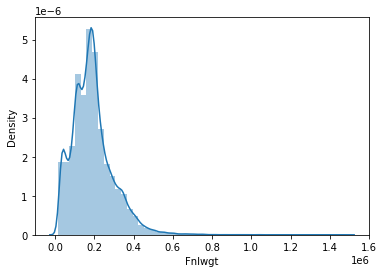

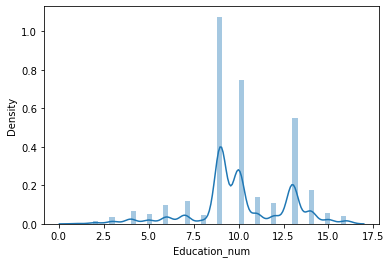

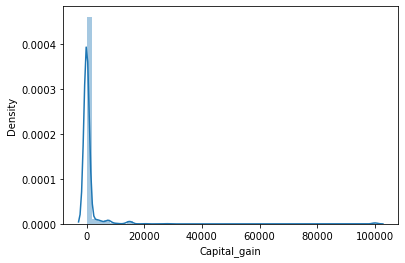

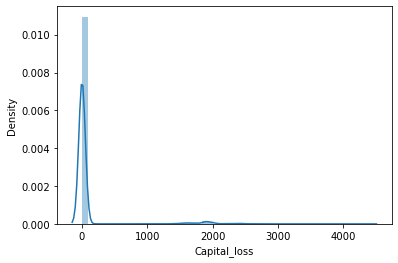

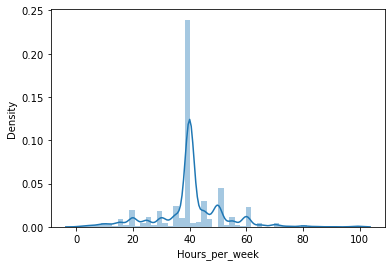

In [239]:
d=df.columns
for i in d:
    if df[i].dtypes!='object':
        sns.distplot(df[i])
        plt.show()

In [240]:
from sklearn.preprocessing  import LabelEncoder

le=LabelEncoder()

df['Workclass']=le.fit_transform(df['Workclass'])         
df['Education']=le.fit_transform(df['Education']) 

df['Marital_status']=le.fit_transform(df['Marital_status'])

df['Occupation']  =le.fit_transform(df['Occupation'])

df['Sex']=le.fit_transform(df['Sex'])

df['Relationship']=le.fit_transform(df['Relationship'])

df['Native_country']=le.fit_transform (df['Native_country'])                 
df['Income']=le.fit_transform (df['Income'])  
df['Race']=le.fit_transform (df['Race'])  

In [241]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
1,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
2,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
3,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
4,37,3,284582,12,14,2,3,5,4,0,0,0,40,38,0


In [242]:
# Numerical columns (Continuous data)
dfnew=df[['Age','Fnlwgt','Education_num' ,'Capital_gain','Hours_per_week','Capital_loss']]

In [243]:
dfnew

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss
0,50,83311,13,0,13,0
1,38,215646,9,0,40,0
2,53,234721,7,0,40,0
3,28,338409,13,0,40,0
4,37,284582,14,0,40,0
...,...,...,...,...,...,...
32555,27,257302,12,0,38,0
32556,40,154374,9,0,40,0
32557,58,151910,9,0,40,0
32558,22,201490,9,0,20,0


In [244]:
df.drop(columns =['Age','Fnlwgt','Education_num' ,'Capital_gain','Hours_per_week','Capital_loss'],inplace=True)

In [245]:
df.head()

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,5,9,2,3,0,4,1,38,0
1,3,11,0,5,1,4,1,38,0
2,3,1,2,5,0,2,1,38,0
3,3,9,2,9,5,2,0,4,0
4,3,12,2,3,5,4,0,38,0


# Now will apply skewness removal and Outliers only on continuous columns i.e. dfnew

In [246]:
from scipy.stats import zscore
z = np.abs(zscore(dfnew))
z

array([[0.83709708, 1.0087417 , 1.13477863, 0.14591373, 2.22212013,
        0.21666301],
       [0.04264043, 0.24504633, 0.42002663, 0.14591373, 0.03542999,
        0.21666301],
       [1.05703146, 0.42576955, 1.19742926, 0.14591373, 0.03542999,
        0.21666301],
       ...,
       [1.42358875, 0.3588108 , 0.42002663, 0.14591373, 0.03542999,
        0.21666301],
       [1.21562378, 0.11092744, 0.42002663, 0.14591373, 1.65520046,
        0.21666301],
       [0.98372   , 0.92986178, 0.42002663, 1.88840054, 0.03542999,
        0.21666301]])

In [247]:
threshold = 3
print(np.where(z>3))

(array([    9,    22,    27, ..., 32524, 32524, 32530], dtype=int64), array([4, 5, 4, ..., 0, 4, 4], dtype=int64))


In [248]:
dfnew1=dfnew[(z<3).all(axis=1)]

In [249]:
dfnew1

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss
0,50,83311,13,0,13,0
1,38,215646,9,0,40,0
2,53,234721,7,0,40,0
3,28,338409,13,0,40,0
4,37,284582,14,0,40,0
...,...,...,...,...,...,...
32555,27,257302,12,0,38,0
32556,40,154374,9,0,40,0
32557,58,151910,9,0,40,0
32558,22,201490,9,0,20,0


dfnew1 dataset : We have lost 2733 rows that is 8% of the data loss is there.

# Checking the skewness and removal of the same

In [250]:
dfnew1.skew()

Age                0.491112
Fnlwgt             0.634168
Education_num     -0.170298
Capital_gain       4.943642
Hours_per_week    -0.354170
Capital_loss      29.661241
dtype: float64

We can see that capital loss and capital gain have huge skewness

As we can see that all the skewness have been removed correctly

In [251]:
dfnew1.shape

(29827, 6)

In [252]:
df.shape

(32560, 9)

In [253]:
df.head()

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,5,9,2,3,0,4,1,38,0
1,3,11,0,5,1,4,1,38,0
2,3,1,2,5,0,2,1,38,0
3,3,9,2,9,5,2,0,4,0
4,3,12,2,3,5,4,0,38,0


In [254]:
dfnew1[['Workclass','Occupation','Native_country','Marital_status','Education','Relationship','Race','Sex','Income']]=df[['Workclass','Occupation','Native_country','Marital_status','Education','Relationship','Race','Sex','Income']]

In [255]:
dfnew1.shape

(29827, 15)

In [256]:
dfnew1.head()

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss,Workclass,Occupation,Native_country,Marital_status,Education,Relationship,Race,Sex,Income
0,50,83311,13,0,13,0,5,3,38,2,9,0,4,1,0
1,38,215646,9,0,40,0,3,5,38,0,11,1,4,1,0
2,53,234721,7,0,40,0,3,5,38,2,1,0,2,1,0
3,28,338409,13,0,40,0,3,9,4,2,9,5,2,0,0
4,37,284582,14,0,40,0,3,3,38,2,12,5,4,0,0


In [257]:
df=dfnew1

In [258]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss,Workclass,Occupation,Native_country,Marital_status,Education,Relationship,Race,Sex,Income
0,50,83311,13,0,13,0,5,3,38,2,9,0,4,1,0
1,38,215646,9,0,40,0,3,5,38,0,11,1,4,1,0
2,53,234721,7,0,40,0,3,5,38,2,1,0,2,1,0
3,28,338409,13,0,40,0,3,9,4,2,9,5,2,0,0
4,37,284582,14,0,40,0,3,3,38,2,12,5,4,0,0


In [259]:
df.shape

(29827, 15)

In [260]:
df.isnull().sum()

Age               0
Fnlwgt            0
Education_num     0
Capital_gain      0
Hours_per_week    0
Capital_loss      0
Workclass         0
Occupation        0
Native_country    0
Marital_status    0
Education         0
Relationship      0
Race              0
Sex               0
Income            0
dtype: int64

In [261]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss,Workclass,Occupation,Native_country,Marital_status,Education,Relationship,Race,Sex,Income
0,50,83311,13,0,13,0,5,3,38,2,9,0,4,1,0
1,38,215646,9,0,40,0,3,5,38,0,11,1,4,1,0
2,53,234721,7,0,40,0,3,5,38,2,1,0,2,1,0
3,28,338409,13,0,40,0,3,9,4,2,9,5,2,0,0
4,37,284582,14,0,40,0,3,3,38,2,12,5,4,0,0


In [262]:
df['Capital_gain'].value_counts()

0        27414
15024      335
7688       277
7298       242
3103        96
         ...  
6097         1
18481        1
1639         1
1455         1
1111         1
Name: Capital_gain, Length: 111, dtype: int64

# Seperating target and independent variable

In [263]:
x=df.drop(('Income'), axis=1)

In [264]:
y=df['Income']

In [265]:
x

,Age,Fnlwgt,Education_num,Capital_gain,Hours_per_week,Capital_loss,Workclass,Occupation,Native_country,Marital_status,Education,Relationship,Race,Sex
0,50,83311,13,0,13,0,5,3,38,2,9,0,4,1
1,38,215646,9,0,40,0,3,5,38,0,11,1,4,1
2,53,234721,7,0,40,0,3,5,38,2,1,0,2,1
3,28,338409,13,0,40,0,3,9,4,2,9,5,2,0
4,37,284582,14,0,40,0,3,3,38,2,12,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,257302,12,0,38,0,3,12,38,2,7,5,4,0
32556,40,154374,9,0,40,0,3,6,38,2,11,0,4,1
32557,58,151910,9,0,40,0,3,0,38,6,11,4,4,0
32558,22,201490,9,0,20,0,3,0,38,4,11,3,4,1


In [266]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32555    0
32556    1
32557    0
32558    0
32559    1
Name: Income, Length: 29827, dtype: int32

# Handling Imbalance Target variable Using Over-Sampling

In [267]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

In [268]:
y.value_counts()

0    23173
1     6654
Name: Income, dtype: int64

In [269]:
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)

In [270]:
y_smote.value_counts()

1    23173
0    23173
Name: Income, dtype: int64

In [271]:
import  statistics as  st

from sklearn.model_selection import train_test_split
from  sklearn.linear_model   import LogisticRegression

In [272]:
x_train,x_test,y_train,y_test = train_test_split(x_smote,y_smote,test_size=.30,random_state=42)

# Scaling

In [273]:
# Using standard scaler to make all data of equal length

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

# Model Selection

In [274]:
#Using Logistic Regression 
lr = LogisticRegression()
lr.fit(x_train, y_train)
print("Accuracy is", lr.score(x_test, y_test)*100)
# cross validation - it is used for better validation of model
score = cross_val_score(lr, x_train, y_train, cv=5)
print("Cross validation is",np.mean(score)*100)

Accuracy is 76.84838895281933
Cross validation is 77.17156027491463


In [275]:
#Using K nearest neighbors(KNN) Classifier
knn = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
knn.fit(x_train,y_train)
print("Accuracy is", knn.score(x_test, y_test)*100)
# cross validation - it is used for better validation of model
score = cross_val_score(knn, x_train, y_train, cv=5)
print("Cross validation is",np.mean(score)*100)

Accuracy is 85.66599539700806
Cross validation is 84.83756015824181


In [276]:
#Using GaussianNB 
gauss = GaussianNB()
gauss.fit(x_train,y_train)
print("Accuracy is", gauss.score(x_test, y_test)*100)
# cross validation - it is used for better validation of model
score = cross_val_score(gauss, x_train, y_train, cv=5)
print("Cross validation is",np.mean(score)*100)

Accuracy is 79.33688147295742
Cross validation is 79.23986651791833


In [277]:
from sklearn.ensemble  import AdaBoostClassifier
from  sklearn.metrics import confusion_matrix, classification_report ,accuracy_score

In [278]:
#Using AdaBoostClassifier
ad=AdaBoostClassifier( n_estimators=50)
ad.fit(x_train, y_train)
adprd=ad.predict(x_test)
print("Accuracy score is",accuracy_score(y_test,adprd))
print(confusion_matrix(y_test, adprd))
print(classification_report(y_test,adprd))

Accuracy score is 0.8555092059838896
[[5761 1223]
 [ 786 6134]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      6984
           1       0.83      0.89      0.86      6920

    accuracy                           0.86     13904
   macro avg       0.86      0.86      0.86     13904
weighted avg       0.86      0.86      0.86     13904



In [279]:
#Using Decision Tree Classifier
dtc=DecisionTreeClassifier()
dtc.fit(x_train,y_train)
preddtc=dtc.predict(x_test)
print("acccuracy score" , accuracy_score(y_test,preddtc))
print("confusion matrix", confusion_matrix(y_test,preddtc))
print("clasification report",classification_report(y_test,preddtc))  

# cross validation - it is used for better validation of model
score = cross_val_score(dtc, x_train, y_train, cv=5)
print("Cross validation is",np.mean(score)*100)

acccuracy score 0.8508342922899885
confusion matrix [[5911 1073]
 [1001 5919]]
clasification report               precision    recall  f1-score   support

           0       0.86      0.85      0.85      6984
           1       0.85      0.86      0.85      6920

    accuracy                           0.85     13904
   macro avg       0.85      0.85      0.85     13904
weighted avg       0.85      0.85      0.85     13904

Cross validation is 84.96391883143227


In [280]:
#Using Random Forest Classifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
predrfc=rfc.predict(x_test)
print("accuracy score is",accuracy_score(y_test,predrfc))
print("confusion matrix", confusion_matrix(y_test,predrfc))
print("classification report",classification_report(y_test,predrfc))

# cross validation - it is used for better validation of model
score = cross_val_score(rfc, x_train, y_train, cv=5)
print("Cross validation is",np.mean(score)*100)

accuracy score is 0.8888089758342923
confusion matrix [[6202  782]
 [ 764 6156]]
classification report               precision    recall  f1-score   support

           0       0.89      0.89      0.89      6984
           1       0.89      0.89      0.89      6920

    accuracy                           0.89     13904
   macro avg       0.89      0.89      0.89     13904
weighted avg       0.89      0.89      0.89     13904

Cross validation is 89.18992569992771


# Auc-Roc Curve

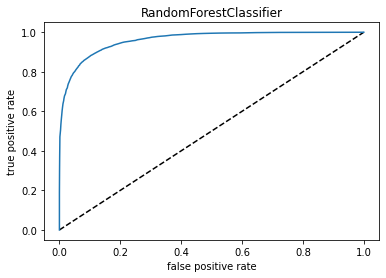

0.8888125790411112


In [281]:
# RandomForestClassifier
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

y_pred_proba= rfc.predict_proba(x_test)[:,1]

fpr,tpr,thresholds=roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='rfr')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('RandomForestClassifier')
plt.show()





auc_score=roc_auc_score(y_test,rfc.predict(x_test))
print(auc_score)

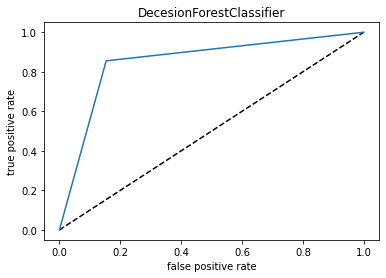

0.8508549682511306


In [282]:
# DTC

from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

y_pred_proba= dtc.predict_proba(x_test)[:,1]

fpr,tpr,thresholds=roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='dtr')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('DecesionForestClassifier')
plt.show()





auc_score=roc_auc_score(y_test,dtc.predict(x_test))
print(auc_score)

# Hyperparameter tuning 

# Hyperparameter tuning of RandomForestClassifier

In [283]:
#Tuning three hyperparameters now, by passing the different values for both parameters

grid_param = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(2,20,3),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split' : range(2,10,2),
    'max_features' : ['auto','random']
}

In [284]:
#selecting Random Forest Classifier for hyperparameter tuning
grid_search = GridSearchCV(estimator=rfc,param_grid=grid_param,cv=5,n_jobs=-1)

In [285]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20, 3),
                         'max_features': ['auto', 'random'],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10, 2)})

In [290]:
#Lets see the best parameter as per theour grid search
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [291]:
rfc = RandomForestClassifier(criterion = 'gini',
 max_depth= 17,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2)

In [292]:
rfc.fit(x_train,y_train)
print("Accuracy is", rfc.score(x_test, y_test)*100)

Accuracy is 88.64355581127732


# Conclusion

We Conclude that our best model is RandomForestClassifier with accuracy 88.64 % 

# Saving the model

In [293]:
#importing joblib
import joblib

#saving the model in a pickle file
joblib.dump(rfc,'Census Income.pkl')

['Census Income.pkl']